<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Time_use_shares_with_vaes_plotting_js_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [0]:
from keras import backend as K
K.clear_session()

In [0]:

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from numpy.random import seed
from tensorflow import set_random_seed
import numpy as np
import imageio

In [0]:
epochs = 2
batch_size = 16

In [0]:
class PlotEpoch(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        
        plot_types(decoder,qt, standard_scaler = False)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                               
        kwargs_write = {'fps':1.0, 'quantizer':'nq'}
        imageio.mimsave('vae.gif', image, fps=1)
        
plot_epoch = PlotEpoch()

In [0]:
callback_list = [
                 keras.callbacks.ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.5,
                     patience = 10,
                     verbose =1 #true
                 ),
                 plot_epoch
]

In [0]:
def make_vae( 
    img_shape = (389+1, ),
    latent_dim = 1, 
    dense_width = 600,
    l2_penalty=0.00001,
    l1_penalty=0.0,
    encoder_dropout_rate=0.5,
    decoder_dropout_rate=0.0,
    entanglement_penalty = 1,
    hidden_n = 1):
  
  input_img = keras.Input(shape=img_shape)

  # The last input indicate to the network whether this is validation
  is_validation = input_img[:,-1] 
  input_data = input_img[:,:-1] 

  x = layers.Dense(dense_width, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(input_data)
  x = layers.Dropout(encoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, activation='relu',kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(encoder_dropout_rate)(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)
  
  # Reduce sampling variance to near zero on validation (idea credit: Shahaf Grofit)
  is_validation_change = is_validation*100
  z_log_var = keras.layers.Subtract()([z_log_var, is_validation_change])
 
  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        is_validation = x[:,-1] 
        input_data = x[:,:-1] 
        x = K.flatten(input_data)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) 
            - entanglement_penalty*K.exp(z_log_var), axis=-1)
        
        # Penalize for variance, but only in training 
        return K.mean(xent_loss + (1-is_validation)*kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x    

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  encoder = Model(input_img,z_mean) # Maybe better if Model(input_data,z_mean)

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])
  print(decoder_input.shape)
  x = layers.Dense(dense_width, activation='relu',kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(decoder_input)
  x = layers.Dropout(decoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, activation='relu',kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(decoder_dropout_rate)(x)


  x = layers.Dense(img_shape[0]-1, activation='relu',kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  # We call our custom layer on the input and the decoded output,
  # to obtain the score. Note that the objective is computed by 
  # this special final layer.
  y = CustomVariationalLayer()([input_img, z_decoded])

  vae = Model(input_img, y)

  vae.compile(optimizer='adam', loss=None) 
  
  return (vae, encoder, decoder)

In [39]:
import pandas as pd 
df=pd.read_csv("https://github.com/yaniv256/VAEs-in-Economics/blob/master/Data/Timeuse/time_shares_only_2013.csv?raw=true")
df

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,540,330,0,35,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,580,95,0,75,0,35,60,25,15,0,0,0,0,0,50,0,0,80,0,309,20,60,0,0,0,5,0,0,0,0,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,450,60,0,170,0,90,105,0,20,0,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0,0,0,0,0,0,40,0,145,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,450,65,680,70,0,30,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,570,90,0,120,0,0,60,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [40]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=1000, random_state=0)
qt = pd.DataFrame(qt_trans.fit_transform(df))
qt.columns = df.columns
qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.571572,0.831832,0.000000,0.304805,0.000000,0.311311,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.997387,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.693193,0.400901,0.000000,0.646146,0.000000,0.508008,0.825325,0.782282,0.791792,0.000000,0.0,0.000000,0.000000,0.000000,0.919920,0.0,0.000000,0.961962,0.0,0.995862,0.851852,0.958458,0.000000,0.000000,0.0,0.871371,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.877878,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.262262,0.304304,0.000000,0.958959,0.000000,0.903403,0.937437,0.000000,

In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(qt, test_size=0.33, random_state=42)
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

(?, 1)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 390)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_9 (Te [(None, 389)]        0           input_9[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 600)          234000      tf_op_layer_strided_slice_9[0][0]
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 600)          0           dense_28[0][0]                   
____________________________________________________________________________________

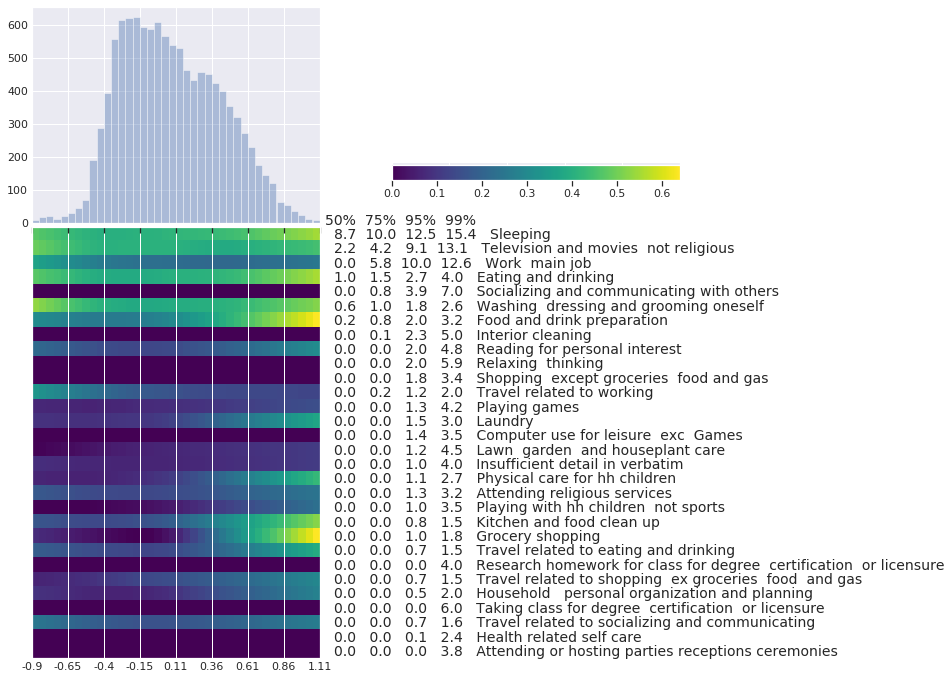

7627/7627 [==============================] - 14s 2ms/sample - loss: 0.1686 - val_loss: 0.1638
Epoch 2/2
7616/7627 [============================>.] - ETA: 0s - loss: 0.1607

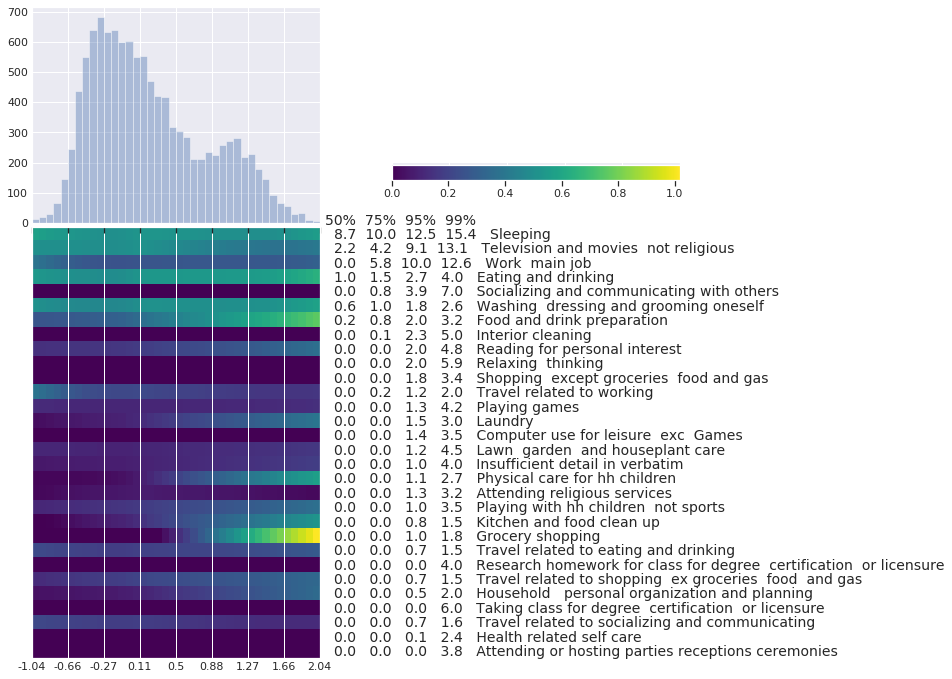

7627/7627 [==============================] - 11s 2ms/sample - loss: 0.1607 - val_loss: 0.1600


In [61]:
seed(42)
set_random_seed(42)
(vae, encoder, decoder) = make_vae(encoder_dropout_rate=0.1)
vae.summary()

fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = callback_list
    )

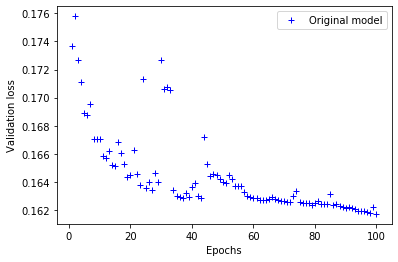

In [0]:
epochs_grid = range(1, epochs+1)
val_loss1 = fitted.history['val_loss']
#val_loss2 = fitted2.history['val_loss']


import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs_grid, val_loss1, 'b+', label='Original model')
# "bo" is for "blue dot"
#plt.plot(epochs_grid, val_loss2, 'bo', label='Alternative model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

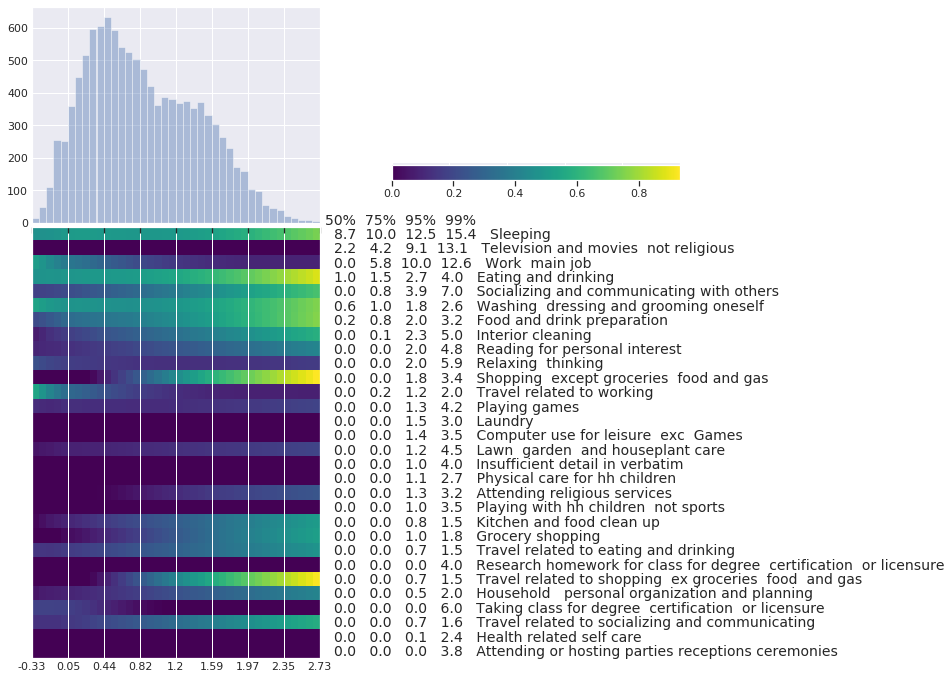

In [43]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import seaborn as sns


def plot_types(decoder, data, n_type = 40, each_hight = 20, approx_width=400, 
               n_activity =  30, lowest_percentile= 0.1, 
               highest_percentile = 99.9, figsize=(10, 10),
               cmap='viridis', n_xlabels=9, spacing = -0.02, standard_scaler=True):
  
  # definitions for the axes
  left, width = 0.05, 0.40
  bottom, height = 0.025, 0.65
  

  rect_scatter = [left, bottom, width, height]
  rect_histx = [left, bottom + height + spacing, width, 0.3]
  rect_colorbar = [left+width+0.1, bottom + height + spacing +0.05, width, 0.03]

  # start with a rectangular Figure
  plt.figure(figsize=figsize)

  ax_scatter = plt.axes(rect_scatter)
  ax_scatter.tick_params(direction='in', top=True, right=True)
  ax_histx = plt.axes(rect_histx)
  ax_histx.tick_params(direction='in', labelbottom=False)
  ax_colorbar = plt.axes(rect_colorbar)
  ax_colorbar.tick_params(direction='in', labelbottom=False, labelleft=False)

  each_width = np.int(np.ceil(approx_width/n_type))
  figure = np.zeros((each_hight*n_activity,n_type*each_width))
  # Linearly spaced coordinates on the unit square were transformed
  # through the inverse CDF (ppf) of the Gaussian
  # to produce values of the latent variables z,
  # since the prior of the latent space is Gaussian
  
  # We need to add a column of ones to indicate validation
  test_examples = data.shape[0]
  flag_1 = np.ones((test_examples,1),dtype=data.values.dtype)
  data = np.concatenate((data.values,flag_1),axis=-1)
  encoded_data=encoder.predict(data)

  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  #print(lowest,highest)

  grid_x = np.linspace(lowest, highest, n_type)

  for i, xi in enumerate(grid_x):
      z_sample = np.array([[xi]])
      x_decoded = decoder.predict(z_sample)
      figure[0:n_activity*each_hight,i*each_width : (i + 1)*each_width] = \
      np.repeat(x_decoded[0,0:n_activity],each_hight).reshape(n_activity*each_hight,1)

  if standard_scaler:
    figure=np.transpose(figure)
    scaler = StandardScaler()
    figure=scaler.fit_transform(figure)
    figure=np.transpose(figure)

  im = ax_scatter.imshow(figure, cmap=cmap)
  plt.colorbar(im, ax= ax_colorbar, orientation='horizontal', fraction=1)

  prec = pd.DataFrame(np.percentile(df,[50, 75, 95, 99],axis=0))

  ax_scatter.text(1.02*n_type*each_width,
                  0.8*each_hight -each_hight, '50%  75%  95%  99%', fontsize=14)

  for i in range(n_activity):

    ax_scatter.text(1.02*n_type*each_width,
                    0.8*each_hight+i*each_hight, 
                    '{:5.1f} {:5.1f} {:5.1f} {:5.1f}   '.format(prec.iloc[0,i]/60, 
                                                             prec.iloc[1,i]/60,
                                                             prec.iloc[2,i]/60,
                                                             prec.iloc[3,i]/60)  
                    + df.columns[i].replace("_", " ")
, fontsize=14)

  bins=np.append(grid_x-(grid_x[1]-grid_x[0])/2,
                 grid_x[n_type-1]+(grid_x[1]-grid_x[0])/2)

  
  ax_scatter.set_xticks( np.linspace(0,n_type*each_width,n_xlabels))
  ax_scatter.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))  
  ax_scatter.set_yticks([])

  sns.set()
  sns.set_style("darkgrid")

  ax_histx.set_xticks( np.linspace(bins[0], bins[n_type], n_xlabels))
  ax_histx.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))
  
  sns.distplot(encoded_data,ax=ax_histx,bins=bins,kde=False,
               rug=False).set_xlim(bins[0],bins[n_type])
  
  plt.savefig('type_plot.png')

  plt.show()

plot_types(decoder,qt, standard_scaler = False);

In [0]:

flag_1 = np.ones((qt.shape[0],1),dtype=qt.values.dtype)
data = np.concatenate((qt.values,flag_1),axis=-1)
encoded_data=encoder.predict(data)
pd.DataFrame(encoded_data)

,0
0,-0.711870
1,-0.059907
2,-0.089188
3,-1.511648
4,-0.638459
...,...
11380,-0.524248
11381,-1.267670
11382,-1.331348
11383,-0.523481


In [0]:
filtered=pd.DataFrame((decoder.predict(encoded_data)))
filtered.columns = df.columns
filtered

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.548491,0.0,0.195173,0.481025,0.155124,0.396089,0.344623,0.201046,0.168398,0.169850,0.0,0.112049,0.100074,0.0,0.0,0.104494,0.0,0.0,0.0,0.0,0.147386,0.000000,0.140946,0.0,0.0,0.069480,0.026121,0.000000,0.0,0.0,0.015694,0.0,0.000000,0.0,0.0,0.051679,0.082920,0.058727,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.518833,0.0,0.118276,0.518173,0.441665,0.466134,0.467792,0.304812,0.249805,0.172533,0.0,0.074382,0.112368,0.0,0.0,0.119821,0.0,0.0,0.0,0.0,0.266812,0.263962,0.215168,0.0,0.0,0.170387,0.022543,0.311739,0.0,0.0,0.011687,0.0,0.057618,0.0,0.0,0.057135,0.133183,0.089167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.526259,0.0,0.097710,0.518420,0.440807,0.456893,0.467169,0.310006,0.252859,0.172405,0.0,0.053705,0.11

In [0]:
filtered-qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,-0.023081,-0.831832,0.195173,0.176221,0.155124,0.084778,0.344623,0.201046,0.168398,0.169850,0.0,0.112049,0.100074,0.000000,0.000000,0.104494,0.000000,0.000000,0.0,0.000000,0.147386,0.000000,0.140946,-0.997387,0.0,0.069480,0.026121,0.000000,0.000000,0.000000,0.015694,0.0,0.000000,0.0,0.000000,0.051679,0.082920,0.058727,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.174360,-0.400901,0.118276,-0.127973,0.441665,-0.041874,-0.357533,-0.477470,-0.541987,0.172533,0.0,0.074382,0.112368,0.000000,-0.919920,0.119821,0.000000,-0.961962,0.0,-0.995862,-0.585040,-0.694497,0.215168,0.000000,0.0,-0.700985,0.022543,0.311739,0.000000,0.000000,0.011687,0.0,0.057618,0.0,-0.877878,0.057135,0.133183,0.089167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [0]:
import time
from google.colab import files

In [0]:
files.download('type_plot.png') 

MessageError: ignored

In [0]:
pd.DataFrame(encoded_data).to_csv("encoded_data.csv", header=False, index=False)


In [0]:
files.download('encoded_data.csv') 

In [0]:
encoder.save_weights('encoder')

In [0]:
files.download('encoder.index') 
files.download('encoder.data-00000-of-00002') 
files.download('encoder.data-00001-of-00002') 

In [0]:
decoder.save_weights('decoder')

In [0]:
files.download('decoder.index') 
files.download('decoder.data-00000-of-00002') 
files.download('decoder.data-00001-of-00002') 

In [0]:
files.download('checkpoint') 

In [0]:
  # We need to add a column of ones to indicate validation
  test_examples = qt.shape[0]
  flag_1 = np.ones((test_examples,1),dtype=qt.values.dtype)
  data = np.concatenate((qt.values,flag_1),axis=-1)
  encoded_data=encoder.predict(data)

  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  

In [0]:
#print(lowest,highest)

  grid_x = np.linspace(lowest, highest, n_type)

  for i, xi in enumerate(grid_x):
      z_sample = np.array([[xi]])
      x_decoded = decoder.predict(z_sample)
      figure[0:n_activity*each_hight,i*each_width : (i + 1)*each_width] = \
      np.repeat(x_decoded[0,0:n_activity],each_hight).reshape(n_activity*each_hight,1)


In [0]:
import seaborn as sns
sns.kdeplot(qt['Sleeping'], qt['Work__main_job'], cmap="Reds", shade=True, bw=.15)

In [0]:
sns.lineplot(x = qt['Sleeping'].sort_values(), y = qt['Work__main_job'].sort_values())

In [0]:
encoded_data.shape

In [0]:
decoder.predict(qt['Sleeping'].sort_values())

In [0]:
fig, ax = plt.subplots()
sns.kdeplot(qt['Sleeping'], qt['Work__main_job'], cmap="Reds", shade=True, bw=.15)
sns.lineplot(x=decoder.predict(qt['Sleeping'].sort_values()), y=decoder.predict(qt['Work__main_job'].sort_values())
plt.show()

In [0]:
  fig, ax = plt.subplots()
    sb.regplot(x='round', y='money', data=firm, ax=ax)
    ax2 = ax.twinx()
    sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')
    sb.plt.show()

In [0]:
qt['Sleeping'].sort_values()

In [0]:
sns.lineplot(data = decoder.predict(qt['Sleeping'].sort_values()))

In [0]:
decoder.predict(qt['Sleeping'].sort_values()).shape

In [0]:
decoder.predict(qt['Sleeping'].sort_values()).summary()

In [0]:
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output
#import imageio

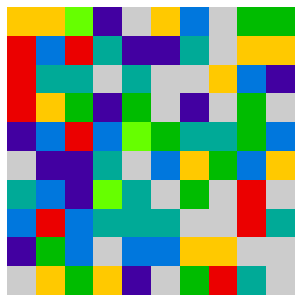

TypeError: ignored

In [0]:
# initialization function: plot the background of each frame

X = np.random.randint(1,10,10*10).reshape(10,10)

def init():
    X = np.random.randint(1,10,10*10).reshape(10,10)
    im.set_data(X)
    return(im,)      
# Setup plotting.
fig = plt.figure()
#plt.close()
ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
# Have a callback save a plot after each epoch
im = ax.imshow(X, cmap='nipy_spectral', interpolation='nearest')
im.set_clim(0, 8)
    
def animate(i):
    # Save frame png
    #im.figure.savefig("vae.png")
    #images.append(imageio.imread('vae.png')) 
    clear_output(wait=True)
    display(im.figure)
    return(im,)

# Make an animated gif
#imageio.mimsave('vae.gif', images)

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=100,
                               interval=100,
                               blit=True)

rc('animation', html='jshtml')
anim
